## Convolutional NNs

References:<br>
Deep Learning with Python and PyTorch, IBM edX course DL0110EN

### Description of the procedure
This serves as a demo on how to use CNN for recognizing vertical and horizontal lines.<br>
Two types of x images with labels: y=0 (vertical), y=1 (horizontal)

<img alt="vertical_horizontal" width="500" caption="sample images" src="images/vertical_horizontal1.png" id="input"/>

<b>CNN architecture to classify image types:</b><br> 
1) convolution layer I - 2 channels (1 input, 2 outputs)<br>
2) pooling layer - 2 channels (2 inputs, 2 outputs)<br>
3) convolution layer II - (2 inputs, 1 output)<br>
4) pooling layer - 1 channel<br>
5) flattening - 2D to 1D (7x7 to 1x49)<br>
6) fully connected NN<br>


<img alt="CNN" width="500" caption="CNN" src="images/convolution_schematic1.png" id="CNN"/>

### Import of libraries and definition of auxiliary functions

In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [2]:
torch.manual_seed(4) #this sets the seed for generating random numbers

<code>plot_channels</code>: to plot the parameters of the convolutional layers  

In [3]:
def plot_channels(W):
    #number of output channels 
    n_out=W.shape[0]
    #number of input channels 
    n_in=W.shape[1]
    w_min=W.min().item()
    w_max=W.max().item()
    fig, axes = plt.subplots(n_out,n_in)
    fig.subplots_adjust(hspace = 0.1)
    out_index=0
    in_index=0
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
    
        if in_index>n_in-1:
            out_index=out_index+1
            in_index=0
              
        ax.imshow(W[out_index,in_index,:,:], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index=in_index+1

    plt.show()

<code>show_data</code>: to plot data sample

In [4]:
def show_data(dataset,sample):

    plt.imshow(dataset.x[sample,0,:,:].numpy(),cmap='gray')
    plt.title('y='+str(dataset.y[sample].item()))
    plt.show()

generating data: black and white images 11 x 11 pixels 

In [5]:
from torch.utils.data import Dataset, DataLoader
class Data(Dataset):
    def __init__(self,N_images=100,offset=0,p=0.9, train=False):
        """
        p:probability that pixel is white  
        N_images:number of images 
        offset:set a random vertical and horizontal offset images by a sample should be less than 3 
        """
        if train==True:
            np.random.seed(1)  
        
        #make images multiple of 2 
        N_images=2*(N_images//2)
        images=np.zeros((N_images,1,11,11))
        start1=3
        start2=1
        self.y=torch.zeros(N_images).type(torch.long)

        for n in range(N_images):
            if offset>0:
        
                low=int(np.random.randint(low=start1, high=start1+offset, size=1))
                high=int(np.random.randint(low=start2, high=start2+offset, size=1))
            else:
                low=4
                high=1
        
            if n<=N_images//2:
                self.y[n]=0
                images[n,0,high:high+9,low:low+3]= np.random.binomial(1, p, (9,3))
            elif  n>N_images//2:
                self.y[n]=1
                images[n,0,low:low+3,high:high+9] = np.random.binomial(1, p, (3,9))
           
        
        
        self.x=torch.from_numpy(images).type(torch.FloatTensor)
        self.len=self.x.shape[0]
        del(images)
        np.random.seed(0)
    def __getitem__(self,index):      
        return self.x[index],self.y[index]
    def __len__(self):
        return self.len

<code>plot_activation</code>: plot out the activations of the Convolutional layers  

In [6]:
def plot_activations(A,number_rows= 1,name=""):
    A=A[0,:,:,:].detach().numpy()
    n_activations=A.shape[0]
    
    
    print(n_activations)
    A_min=A.min().item()
    A_max=A.max().item()

    if n_activations==1:

        # Plot the image.
        plt.imshow(A[0,:], vmin=A_min, vmax=A_max, cmap='seismic')

    else:
        fig, axes = plt.subplots(number_rows, n_activations//number_rows)
        fig.subplots_adjust(hspace = 0.4)
        for i,ax in enumerate(axes.flat):
            if i< n_activations:
                # Set the label for the sub-plot.
                ax.set_xlabel( "activation:{0}".format(i+1))

                # Plot the image.
                ax.imshow(A[i,:], vmin=A_min, vmax=A_max, cmap='seismic')
                ax.set_xticks([])
                ax.set_yticks([])
    plt.show()


Utility function for computing output of convolutions:<br>
it takes a tuple of (h_w) and returns a tuple of (h,w)

In [7]:

def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    #by Duane Nielsen
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

### Data preparation

Load the training dataset with 10000 samples 

In [8]:
train_dataset=Data(N_images=10000)
train_dataset

Load the testing dataset

In [9]:
validation_dataset=Data(N_images=1000,train=False)
validation_dataset

### Data Visualization 

Each element in the rectangular  tensor corresponds to a number representing a pixel intensity  as demonstrated by  the following image.

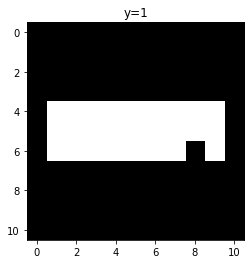

In [10]:
show_data(train_dataset,8000)

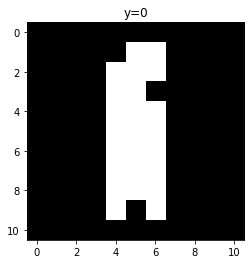

In [11]:
show_data(train_dataset,1)

<a id="ref3"></a>
### Build a Convolutional Neural Network Class 

The input image is 11 x11, the following will change the size of the activations:
<ul>
<il>convolutional layer</il> 
</ul>
<ul>
<il>max pooling layer</il> 
</ul>
<ul>
<il>convolutional layer </il>
</ul>
<ul>
<il>max pooling layer </il>
</ul>

with the following parameters <code>kernel_size</code>, <code>stride</code> and <code> pad</code>.
We use the following  lines of code to change the image before we get to the fully connected layer 

In [12]:
out=conv_output_shape((11,11), kernel_size=2, stride=1, pad=0, dilation=1)
print(out)
out1=conv_output_shape(out, kernel_size=2, stride=1, pad=0, dilation=1)
print(out1)
out2=conv_output_shape(out1, kernel_size=2, stride=1, pad=0, dilation=1)
print(out2)
out3=conv_output_shape(out2, kernel_size=2, stride=1, pad=0, dilation=1)
print(out3)

(10, 10)
(9, 9)
(8, 8)
(7, 7)


Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.

In [13]:
class CNN(nn.Module):
    def __init__(self,out_1=2,out_2=1):
        
        super(CNN,self).__init__()
        #first Convolutional layers 
        self.cnn1=nn.Conv2d(in_channels=1,out_channels=out_1,kernel_size=2,padding=0)
        self.maxpool1=nn.MaxPool2d(kernel_size=2 ,stride=1)

        #second Convolutional layers
        self.cnn2=nn.Conv2d(in_channels=out_1,out_channels=out_2,kernel_size=2,stride=1,padding=0)
        self.maxpool2=nn.MaxPool2d(kernel_size=2 ,stride=1)
        #max pooling 

        #fully connected layer 
        self.fc1=nn.Linear(out_2*7*7,2)
        
    def forward(self,x):
        #first Convolutional layers
        x=self.cnn1(x)
        #activation function 
        x=torch.relu(x)
        #max pooling 
        x=self.maxpool1(x)
        #first Convolutional layers
        x=self.cnn2(x)
        #activation function
        x=torch.relu(x)
        #max pooling
        x=self.maxpool2(x)
        #flatten output 
        x=x.view(x.size(0),-1)
        #fully connected layer
        x=self.fc1(x)
        return x
    
    def activations(self,x):
        #outputs activation is not necessary
        z1=self.cnn1(x)
        a1=torch.relu(z1)
        out=self.maxpool1(a1)
        
        z2=self.cnn2(out)
        a2=torch.relu(z2)
        out=self.maxpool2(a2)
        out=out.view(out.size(0),-1)
        return z1,a1,z2,a2,out        

### Define the CNN classifier, criterion function, optimizer and train the model 

There are 2 output channels for the first layer, and 1 outputs channel for the second layer 

In [14]:
model=CNN(2,1)

we can see the model parameters with the object 

In [15]:
model

CNN(
  (cnn1): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(2, 1, kernel_size=(2, 2), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=49, out_features=2, bias=True)
)

Plot the model parameters for the kernels before training the kernels. The kernels are initialized randomly.

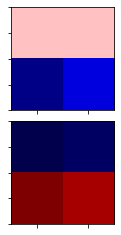

In [16]:

plot_channels(model.state_dict()['cnn1.weight'])


In [17]:
model.state_dict()['cnn1.weight']

tensor([[[[ 0.0596,  0.0591],
          [-0.4085, -0.2900]]],


        [[[-0.4928, -0.4610],
          [ 0.4929,  0.4131]]]])

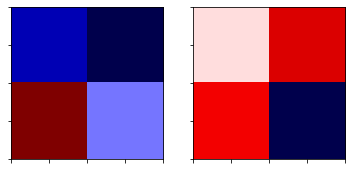

In [18]:
plot_channels(model.state_dict()['cnn2.weight'])

In [19]:
model.state_dict()['cnn2.weight']

tensor([[[[-0.1280, -0.2016],
          [ 0.3014, -0.0187]],

         [[ 0.0671,  0.2090],
          [ 0.1863, -0.2024]]]])

Define the loss function 

In [20]:
criterion=nn.CrossEntropyLoss()

 optimizer class (adaptive momentum estimation - Adam) 

In [21]:
learning_rate=0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Use dataloader for loading training and validation datasets

In [22]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=10)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=20)

Train the model and determine validation accuracy

In [23]:
n_epochs=10
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
cost=0
#n_epochs
for epoch in range(n_epochs):
    cost=0    
    for x, y in train_loader:
      
        optimizer.zero_grad() #clear gradient 
        z=model(x) #make a prediction 
        loss=criterion(z,y) # calculate loss 
        loss.backward() # calculate gradients of parameters 
        optimizer.step() # update parameters 
        cost+=loss.item()
    cost_list.append(cost)    
        
    correct=0
    #perform prediction on the validation  data  
    for x_test, y_test in validation_loader:

        z=model(x_test)
        _,yhat=torch.max(z.data,1)

        correct+=(yhat==y_test).sum().item()
        

    accuracy=correct/N_test

    accuracy_list.append(accuracy)
    



C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Results analysis 

Plot loss and accuracy for the validation data:

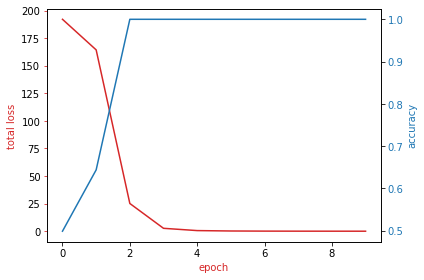

In [24]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

View the results of the parameters for the convolutional layers 

In [25]:
model.state_dict()['cnn1.weight']

tensor([[[[ 0.3869,  0.5034],
          [-0.0552, -0.0767]]],


        [[[-0.4216, -0.2976],
          [ 0.9227,  0.8473]]]])

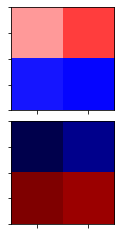

In [26]:
plot_channels(model.state_dict()['cnn1.weight'])

In [27]:
model.state_dict()['cnn1.weight']

tensor([[[[ 0.3869,  0.5034],
          [-0.0552, -0.0767]]],


        [[[-0.4216, -0.2976],
          [ 0.9227,  0.8473]]]])

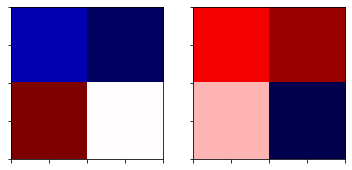

In [28]:
plot_channels(model.state_dict()['cnn2.weight'])

In [29]:
model.state_dict()['cnn2.weight']

tensor([[[[-0.0477, -0.1256],
          [ 0.5358,  0.1972]],

         [[ 0.3771,  0.5006],
          [ 0.2435, -0.1455]]]])

Consider the following sample 

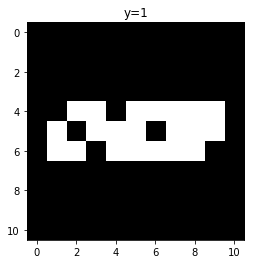

In [40]:
show_data(train_dataset,7000)

Determine the activations 

In [41]:
out=model.activations(train_dataset[7000][0].view(1,1,11,11))
# out=model.activations(train_dataset[0][0].view(1,1,11,11))

Plot them

2


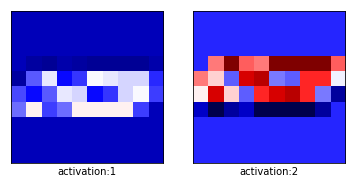

In [52]:
plot_activations(out[0],number_rows=1,name="1st feature map")
plt.show()


2


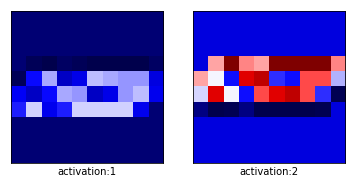

In [50]:
plot_activations(out[1],number_rows=1,name="1st feature map")
plt.show()

1


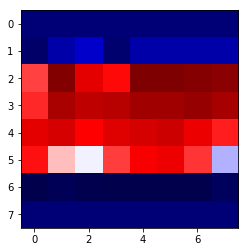

In [51]:
plot_activations(out[2],number_rows=1,name="2nd feature map")
plt.show()

1


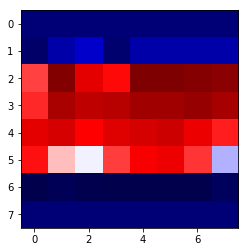

In [53]:
plot_activations(out[3],number_rows=1,name="second feature map")
plt.show()

we save the output of the activation after flattening  

In [54]:
out1=out[4][0].detach().numpy()

we can do the same for a sample  where y=0 

In [55]:
out0=model.activations(train_dataset[0][0].view(1,1,11,11))[4][0].detach().numpy()
out0

array([0.7428652 , 1.8204954 , 2.4719982 , 2.5179658 , 2.5179658 ,
       2.1351912 , 1.0276601 , 0.59945774, 1.3692977 , 1.976858  ,
       2.1431417 , 2.1431417 , 1.9378506 , 1.1047956 , 0.59945774,
       1.3692977 , 2.0209215 , 2.161925  , 2.161925  , 2.0443375 ,
       1.1047956 , 0.59945774, 1.4431126 , 2.156496  , 2.2978828 ,
       2.2978828 , 2.0443375 , 1.0020233 , 0.59945774, 1.4955455 ,
       2.156496  , 2.2978828 , 2.2978828 , 1.9130135 , 0.9667073 ,
       0.59945774, 1.4955455 , 2.1124327 , 2.2790992 , 2.2790992 ,
       1.9122139 , 1.1047956 , 0.61661744, 1.4248356 , 2.064498  ,
       2.1729476 , 2.1729476 , 1.997103  , 1.1047956 ], dtype=float32)

Text(0, 0.5, 'Activation')

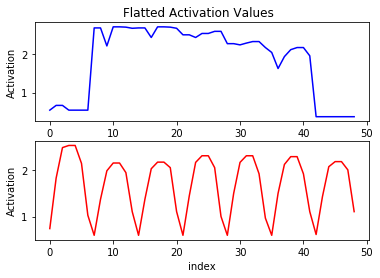

In [57]:
plt.subplot(2, 1, 1)
plt.plot( out1, 'b')
plt.title('Flatted Activation Values  ')
plt.ylabel('Activation')
plt.xlabel('index')
plt.subplot(2, 1, 2)
plt.plot(out0, 'r')
plt.xlabel('index')
plt.ylabel('Activation')